## Masking the Y in the Stickleback assembly

- I want to be able to call SNPs within and between samples on the sex chromosome when I am analysing the Alaskan lake data. . . . 
- But this is problematic due to interspersed regions of X/Y homology and hemizygosity of due to losses on the Y. 

- In Homologous regions, heterozygous positions can be called within individuals of both sexes, but having both X and Y in the assembly will cause reads to map unpredictably across both scaffolds, and affect genotype calling. 
- Removing the Y however would remove Y specific sequence, and thus our ability to characterise diversity among Y haplotypes in the population. 

The solution, which we will examine here, is to mask regions of the Y where there is good homology with the X. This means that both X and Y reads will align to the X chromosome, allowing diploid genotypes to be called there. Leaving Y regions which are mappable only in males unmasked ensures that Y reads in males can align there.

So the proceedure will go as follows. 

1. Align male and female reads to the genome containing Autosomes and Y only (no X). 2. Quantify read depth in narrow windows. This will allow me to see where X reads are able to map (2n coverage) vs regions with only Y reads mapping. The 2n regions would thus be the positions to mask. 
3. Align data to the genome with Autosomes and X.
4. Align data to the genome with Autosomes, X and Y masked regions. 
5. Compare coverage of 2n X windows with the X only, and with the masked Y in there . . . windows which are 2n in the Auto & X alignment should still be 2n when the Y is in there. 
6. Align data to the A + X + Y reference, where the Y is unmasked. Again, compare the 2n X windows to see the before and after effect. 

This is the way

### Alignments 

I have data from 24 blackspotted individuals which will be aligned to 3 different references, which differ in which sex chromosomes are included. . . 

1. A + X - Running
2. A + Y - Running
3. A + X + Y (masked)
4. A + X + Y (unmasked) - ALGN DONE, DEPTHS DONE

In [9]:
def Combine_depths(wd, suffix, sex_info_dict = None):
    
    """
    Combine the outputs of DeepTools coverage outputs.
    
    wd      - directory containing all of the coverage files
    suffix  - suffix for all of the depth files. 
    
    """
    
    import os

    scaff_dict = {}

    samples = []

    for file in os.listdir(wd):

        if file.endswith(suffix):

            sample = "_".join(file.split("_")[:4])

            samples.append(sample)

            with open("%s/%s" % (wd, file)) as covs:

                for line in covs:

                    scaff = line.split()[0]
                    strt = int(line.split()[1])
                    stop = int(line.split()[2])
                    depth = line.split()[3]

                    if scaff not in scaff_dict:
                        scaff_dict[scaff] = {}


                    ## split annoyingly merged windows!!

                    if stop - strt != 1000:

                        ## numbr of bins merged
                        N_merged_bins = int((stop-strt)/1000)
                        #print(sample, strt)
                        for i in range(1,N_merged_bins+1):

                            new_stop = strt+(i*1000)

                            if i == 1:
                                new_strt = strt
                            else:
                                new_strt = strt+((i-1)*1000)

                            window = "%s_%s" % (new_strt, new_stop)

                            if window not in scaff_dict[scaff]:
                                #print(sample, window)
                                scaff_dict[scaff][window] = []

                            scaff_dict[scaff][window].append(depth)

                    else:

                        window = "%s_%s" % (strt, stop)

                        if window not in scaff_dict[scaff]:
                            scaff_dict[scaff][window] = []

                        scaff_dict[scaff][window].append(depth)


            print("%s done!!" % sample)



    with open("%s/Combined_depths.out" % wd, 'w') as outfile:

        outfile.write("CHROM\tSTART\tSTOP\t%s\n" % "\t".join(samples))

        for scaff in sorted(scaff_dict.keys()):

            for window in sorted(scaff_dict[scaff].keys()):

                outfile.write("%s\t%s\t%s\t%s\n" % (scaff, window.split("_")[0], window.split("_")[1], "\t".join(scaff_dict[scaff][window])))

    print("\nDone, output here: %s/Combined_depths.out\n" % wd)

In [24]:
def M_vs_F_cov(infilepath, outfilename, males = None, females = None, min_samples = 0, min_mean_depth = 5):
    
    
    """
    Function to calculate male vs female coverage from DeepTools outputs
    
    infilepath         - Full input file path
    outfilename        - Name of file to output coverage ratios (will be in same path as input)
    males              - Python list of male names exactly as they appear in the input file
    females            - Python list of female names exactly as they appear in the input file
    min_samples        - Min number of samples with >0 coverage at each window (of either sex)
    min_mean_depth     - Min average depth at a window that must be present in at least 1 sex
    
    """
    
    import numpy as np

    outpath = "%s/%s" % (infilepath.rpartition("/")[0], outfilename)
    
    outhandle = open(outpath, 'w')

    outhandle.write("CHROM\tSTART\tSTOP\tCENTRE\tM-F_Depth\n")
    
    outdict = {}
    
    
    ### Get sex information
    
    if any([males == None, females == None]):
        sys.exit("Sex information not supplied!)")
    
    
    male_covs = []
    female_covs = []
    
    with open(infilepath) as allcovs:

        samples = next(allcovs).split()[3:]

        index = 0
        male_indices = []
        female_indices = []
        
        for sample in samples:

            if sample in males:
                male_indices.append(index)

            elif sample in females:
                female_indices.append(index)

            index += 1
        
        print("Males found", len(male_indices))
        print("Females found", len(female_indices))
        
        for line in allcovs:

            n_males = 0
            n_females = 0

            sum_male = 0
            sum_female = 0

            scaff = "Chr%s" % str(line.split()[0].split(".")[0][-4:]).zfill(4)
            strt = int(line.split()[1])
            stop = int(line.split()[2])

            centre = strt+((stop-strt)/2)
            window = "%s_%s" % (strt, stop)

            data = line.split()[3:]

            data_index = 0
            male_data = []
            female_data = []

            for depth in data:
                
                if data_index in male_indices:
                    male_data.append(float(depth))
                    n_males += 1

                elif data_index in female_indices:
                    female_data.append(float(depth))                    
                    n_females += 1

                data_index += 1
            
            mean_depth_male = np.mean(male_data)
            mean_depth_female = np.mean(female_data)
            

            if any([mean_depth_male > min_mean_depth, mean_depth_female > min_mean_depth]):
                male_average = np.mean(male_data)  ## + 0.0001 to avoid division by zero
                female_average = np.mean(female_data)


            male_covs.append(male_average)
            female_covs.append(female_average)
                
            ratio = np.round(male_average / female_average, 2)

            #else:
            #    ratio = "NA"

            
            if scaff not in outdict:
                
                outdict[scaff] = {}
                
            outdict[scaff][strt] = "\t".join([scaff, str(strt), str(stop), str(centre), str(ratio)])    
        
        
        for scaff in sorted(outdict.keys()):
            
            for pos in sorted(outdict[scaff].keys()):
            
                outhandle.write("%s\n" % outdict[scaff][pos])
    
    
    outhandle.close()
    
    return male_covs, female_covs
    
    

In [32]:
def Plot_cov(infilepath, scaffs = None, myXlims = None, myYlims = None, moving_average_offset = 2500, avg_window = None, features = None):
    
    """
    Plots coverage data and writes output to a file
    
    """
    
    
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 14})
    
    Scaff_dict = {}

    with open(infilepath) as cov_diffs:

        headers = next(cov_diffs)


        for line in cov_diffs:

            scaff = line.split()[0]
            pos = int(float(line.split()[3]))
            
            if line.split()[4] == "NA":
                diff = np.nan
            else:
                diff = float(line.split()[4])

            
            if scaff not in Scaff_dict:
                Scaff_dict[scaff] = {}
                Scaff_dict[scaff]["centre"] = []
                Scaff_dict[scaff]["ratio"] = []

            Scaff_dict[scaff]["centre"].append(pos)
            Scaff_dict[scaff]["ratio"].append(diff)


                
    output_DF = pd.DataFrame()
    
    if scaffs:
        
        scaffs_to_plot = scaffs
        
    else:
        
        scaffs_to_plot = sorted(Scaff_dict.keys())
        
    
    print("Plotting scaffolds: %s" % ", ".join(scaffs_to_plot))
    plt.figure(figsize = (20,5*len(scaffs_to_plot)))
    
    scaff_index = 1
    for scaff in scaffs_to_plot:


        plt.subplot(len(scaffs_to_plot),1,scaff_index)
        plt.title(scaff)

            
        x = np.array(Scaff_dict[scaff]["centre"])
            
        y = np.array(Scaff_dict[scaff]["ratio"], dtype="float")
                     
        #print(len(x), len(y))
        
        #print(y)
        ymask = np.isfinite(y)
        
        x_masked = x[ymask]
        y_masked = y[ymask]
        
            
        ratio_pddf = pd.DataFrame(Scaff_dict[scaff]["ratio"], dtype='Float64')
        
        plt.scatter([i/1000000 for i in Scaff_dict[scaff]["centre"]],ratio_pddf, c = "black", s = 5, alpha = 0.5)
        
        
        rolling_mean = ratio_pddf.rolling(10, min_periods=1).mean()
        rolling_STD_lower = rolling_mean - ratio_pddf.rolling(10, min_periods=1).std()
        rolling_STD_upper = rolling_mean + ratio_pddf.rolling(10, min_periods=1).std()
        
        #print([i[0] for i in rolling_STD_lower.values])
        
        plt.plot([(i-moving_average_offset)/1000000 for i in Scaff_dict[scaff]["centre"]], rolling_mean, c = "red", linewidth = 1)
        
        plt.fill_between([(i-moving_average_offset)/1000000 for i in Scaff_dict[scaff]["centre"]], 
                         [i[0] for i in rolling_STD_lower.values], 
                         [i[0] for i in rolling_STD_upper.values], 
                         alpha = 0.2,
                         color = "red")
        
        df = pd.DataFrame()
        
        df["Chromosomes"] = [scaff]*len(ratio_pddf)
        df["Window_centres"] = [(i)/1000000 for i in Scaff_dict[scaff]["centre"]]
        df["M_over_F_Cov_ratio"] = ratio_pddf
        df["Rolling_mean_10kb"] = rolling_mean
        df["rolling_STD_lowwer"] = rolling_STD_lower
        df["rolling_STD_upper"] = rolling_STD_upper
        
        
        output_DF = output_DF.append(df)
        
        if myXlims:
            min_x = myXlims[0]
            max_x = myXlims[1]
            plt.xlim(min_x, max_x)
        else:
            min_x = min([(i-moving_average_offset)/1000000 for i in Scaff_dict[scaff]["centre"]])
            max_x = max([(i-moving_average_offset)/1000000 for i in Scaff_dict[scaff]["centre"]])
            plt.xlim(min_x, max_x)
        
        if myYlims:
            min_y = myYlims[0]
            max_y = myYlims[1]
            plt.ylim(min_y, max_y)
            
        else:
            min_y = min(rolling_mean)
            max_y = max(rolling_mean)
            plt.ylim(min_y, max_y) 
        
        
        if features: # a list of tuples (or lists of 2 x coordinates)
            for feature in features:
                plt.hlines(max_y - (1.5*(max_y/10)), feature[0], feature[1])
                plt.text(feature[0], max_y - (max_y/10), feature[2])
        
        
        if avg_window:
            plt.vlines(avg_window[0], min_y, max_y, color = "black", linestyle = "dashed", linewidth = 0.5)
            plt.vlines(avg_window[1], min_y, max_y, color = "black", linestyle = "dashed", linewidth = 0.5)
        
            NewDF = output_DF.loc[(output_DF["Window_centres"] >= avg_window[0]) & (output_DF["Window_centres"] <= avg_window[1])]
            
            print("Region mean = %s +- %s" % (np.round(np.mean(NewDF["M_over_F_Cov_ratio"]),2), np.round(np.std(NewDF["M_over_F_Cov_ratio"]),2)))
        
        scaff_index += 1

    plt.savefig("%s_M_over_F_coverage_plot.pdf" % infilepath.rpartition(".")[0])
    plt.show()
    
    return output_DF

    


In [11]:
sex_info_path = "/Users/dj20y461/Data_temp/Stickleback/Y_masking/A_Y/depths/samples.txt"

males = []
females = []
with open(sex_info_path) as sex_info:
    for line in sex_info:
        if line.split()[1] == "M":
            males.append(line.split()[0])
        elif line.split()[1] == "F":
            females.append(line.split()[0])


In [5]:
sex_info_dict

{'LG_HL_19T_372': 'M',
 'LG_HL_19T_384': 'F',
 'LG_LO_19T_222': 'M',
 'SL_CL_19T_365': 'M',
 'SL_HL_19T_228': 'F',
 'SL_HL_19T_290': 'F',
 'SL_LO_19T_186': 'M',
 'TL_CC_19T_115': 'F',
 'TL_CC_19T_117': 'F',
 'TL_GL_19T_212': 'F',
 'TL_LL_19T_267': 'M',
 'TL_LO_19T_106': 'M',
 'WB_LL_19T_259': 'M',
 'WB_LL_19T_264': 'F',
 'WB_LL_19T_269': 'F',
 'WB_LO_19T_179': 'F',
 'WK_RL_19T_187': 'M',
 'WT_GL_19T_036': 'M',
 'WT_LL_19T_001': 'F',
 'WT_LL_19T_045': 'F',
 'WT_LL_19T_186': 'F',
 'WT_LP_19T_101': 'F',
 'WT_LP_19T_102': 'F'}

In [10]:
Combine_depths("/Users/dj20y461/Data_temp/Stickleback/Y_masking/A_Y/depths/",
               "depth")

WK_RL_19T_187 done!!
TL_CC_19T_117 done!!
TL_GL_19T_212 done!!
TL_LL_19T_267 done!!
WB_LL_19T_259 done!!
LG_HL_19T_384 done!!
TL_CC_19T_115 done!!
WT_GL_19T_036 done!!
WB_LL_19T_269 done!!
WB_LO_19T_179 done!!
LG_HL_19T_372 done!!
WT_LP_19T_101 done!!
SL_CL_19T_365 done!!
WT_LL_19T_045 done!!
SL_HL_19T_228 done!!
WT_LL_19T_001 done!!
WB_LL_19T_264 done!!
SL_LO_19T_186 done!!
SL_HL_19T_290 done!!
LG_LO_19T_222 done!!
WT_LL_19T_186 done!!
WT_LP_19T_102 done!!
TL_LO_19T_106 done!!

Done, output here: /Users/dj20y461/Data_temp/Stickleback/Y_masking/A_Y/depths//Combined_depths.out



In [27]:
M_covs, F_covs, = M_vs_F_cov("/Users/dj20y461/Data_temp/Stickleback/Y_masking/A_Y/depths/Combined_depths.out",
                             "M_vs_F_depths.out",
                             males = males,
                             females = females,
                             min_samples = 10,
                             min_mean_depth=0.05)
           

Males found 9
Females found 14


/var/folders/4s/2dr1mnzx4_x3lb4mtkpcczgr0000gn/T/ipykernel_40444/2804394825.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.round(male_average / female_average, 2)


In [30]:
scaffs = ["chrI",
"chrII",
"chrIII",
"chrIV",
"chrIX",
"chrV",
"chrVI",
"chrVII",
"chrVIII",
"chrX",
"chrXI",
"chrXII",
"chrXIII",
"chrXIV",
"chrXIX",
"chrXV",
"chrXVI",
"chrXVII",
"chrXVIII",
"chrXX",
"chrXXI",
"chrY"]

In [34]:
help(Plot_cov)

Help on function Plot_cov in module __main__:

Plot_cov(infilepath, scaffs=None, myXlims=None, myYlims=None, moving_average_offset=2500, avg_window=None, features=None)
    Plots coverage data and writes output to a file



Plotting scaffolds: chrI, chrII, chrIII, chrIV, chrIX, chrV, chrVI, chrVII, chrVIII, chrX, chrXI, chrXII, chrXIII, chrXIV, chrXIX, chrXV, chrXVI, chrXVII, chrXVIII, chrXX, chrXXI, chrY


KeyError: 'chrI'

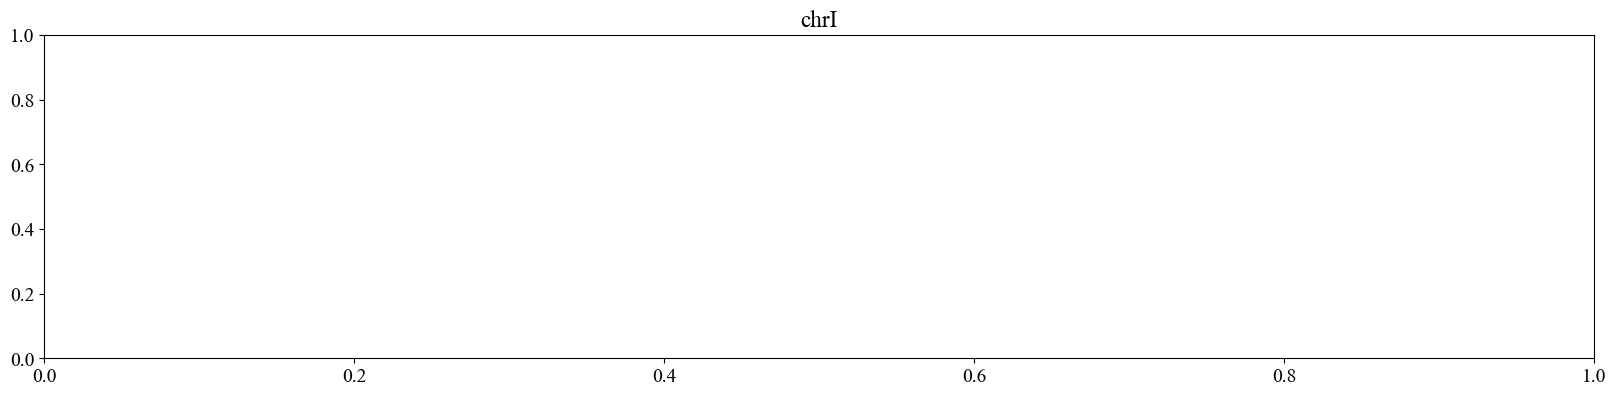

In [35]:
OUDF = Plot_cov("/Users/dj20y461/Data_temp/Stickleback/Y_masking/A_Y/depths/M_vs_F_depths.out",
                scaffs = scaffs,
                myXlims = (0, 42),
                myYlims = (0, 2))

In [14]:
help(M_vs_F_cov)

Help on function M_vs_F_cov in module __main__:

M_vs_F_cov(infilepath, outfilename, males=None, females=None, min_samples=0, min_mean_depth=5)
    Function to calculate male vs female coverage from DeepTools outputs
    
    infilepath         - Full input file path
    outfilename        - Name of file to output coverage ratios (will be in same path as input)
    males              - Python list of male names exactly as they appear in the input file
    females            - Python list of female names exactly as they appear in the input file
    min_samples        - Min number of samples with >0 coverage at each window (of either sex)
    min_mean_depth     - Min average depth at a window that must be present in at least 1 sex

